# Prepare Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import cv2
import os
import random
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG19
from keras.callbacks import ReduceLROnPlateau

In [16]:
labels = ['dandelion', 'daisy', 'tulip', 'sunflower', 'rose']

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (224, 224))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [17]:
data = get_data("flowers-recognition/flowers")

OpenCV(4.3.0) /io/opencv/modules/imgproc/src/resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.3.0) /io/opencv/modules/imgproc/src/resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.3.0) /io/opencv/modules/imgproc/src/resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



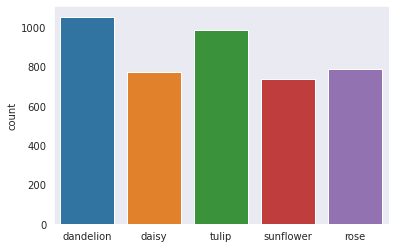

In [18]:
sns.set_style('dark')

l = []
for i in data:
    l.append(labels[i[1]])
sns.countplot(l)

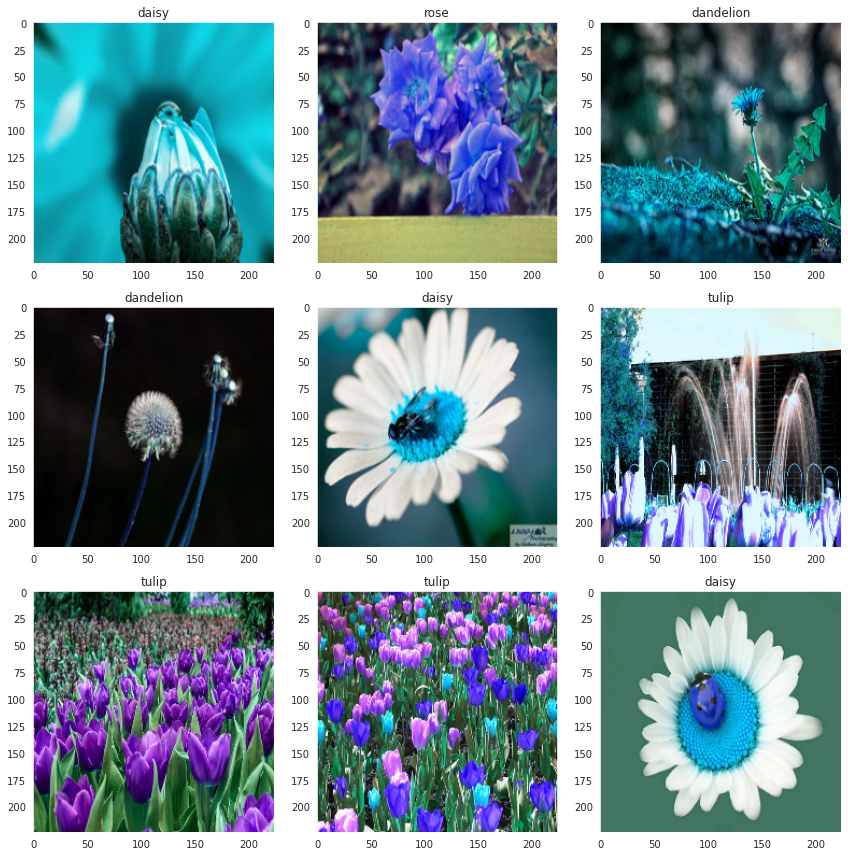

In [19]:
fig, ax = plt.subplots(3,3)
fig.set_size_inches(12,12)
for i in range(3):
    for j in range(3):
        l = random.randint(0, len(data))
        ax[i,j].imshow(data[l][0])
        ax[i,j].set_title(labels[data[l][1]])

plt.tight_layout()

In [20]:
x = []
y = []
img_size = 224

for feature, label in data:
    x.append(feature)
    y.append(label)
    
x = np.array(x) / 255
x = x.reshape(-1, img_size, img_size, 3)
y = np.array(y)

label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=21)

# Using Kaggle TPU 

In [21]:
del x, y, data

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Transfer Learning from VGG19

In [22]:
with strategy.scope():
    pre_trained_model = VGG19(input_shape=(224,224,3), include_top=False, weights='imagenet')
    
    for layer in pre_trained_model.layers[:19]:
        layer.trainable = False
    
    model = Sequential([pre_trained_model, 
                       MaxPool2D((2,2), strides=2),
                       Flatten(),
                       Dense(5, activation='softmax')])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 23045     
Total params: 20,047,429
Trainable params: 4,742,661
Non-trainable params: 15,304,768
_________________________________________________________________


# Train Model

In [23]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)

history = model.fit(X_train, y_train, batch_size=64, epochs=12, 
                    validation_data=(X_test, y_test), callbacks=[lr_reduction])

Epoch 1/12
55/55 [==============================] - 20s 367ms/step - loss: 0.8842 - accuracy: 0.6848 - val_loss: 0.6197 - val_accuracy: 0.7988 - lr: 0.0010
Epoch 2/12
55/55 [==============================] - 5s 89ms/step - loss: 0.3896 - accuracy: 0.8600 - val_loss: 0.5901 - val_accuracy: 0.8069 - lr: 0.0010
Epoch 3/12
55/55 [==============================] - 5s 90ms/step - loss: 0.2685 - accuracy: 0.8997 - val_loss: 0.6102 - val_accuracy: 0.8197 - lr: 0.0010
Epoch 4/12
55/55 [==============================] - 5s 89ms/step - loss: 0.1707 - accuracy: 0.9404 - val_loss: 0.5892 - val_accuracy: 0.8324 - lr: 0.0010
Epoch 5/12
55/55 [==============================] - 5s 88ms/step - loss: 0.1080 - accuracy: 0.9665 - val_loss: 0.6498 - val_accuracy: 0.8335 - lr: 0.0010
Epoch 6/12
55/55 [==============================] - 5s 88ms/step - loss: 0.0802 - accuracy: 0.9780 - val_loss: 0.5977 - val_accuracy: 0.8486 - lr: 0.0010
Epoch 7/12
55/55 [==============================] - 5s 90ms/step - loss: 0

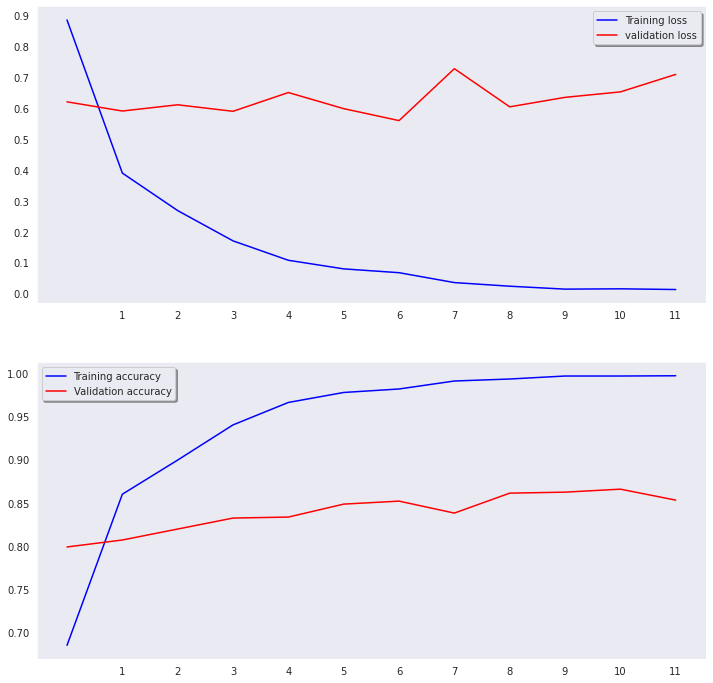

In [24]:
plt.figure(figsize=(12, 12))

plt.subplot(211)
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.xticks(np.arange(1, 12, 1))
plt.yticks(np.arange(0, 1, 0.1))
plt.legend(loc='best', shadow=True)

plt.subplot(212)
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.xticks(np.arange(1, 12, 1))
plt.legend(loc='best', shadow=True)

# Test Model

In [25]:
predictions = model.predict_classes(X_test)
y_test_inv = label_binarizer.inverse_transform(y_test)
print(classification_report(y_test_inv, predictions, target_names=labels))

              precision    recall  f1-score   support

   dandelion       0.84      0.92      0.88       210
       daisy       0.89      0.82      0.86       154
       tulip       0.87      0.79      0.83       197
   sunflower       0.86      0.95      0.91       147
        rose       0.81      0.77      0.79       157

    accuracy                           0.85       865
   macro avg       0.85      0.85      0.85       865
weighted avg       0.85      0.85      0.85       865



Text(87.0, 0.5, 'True Labels')

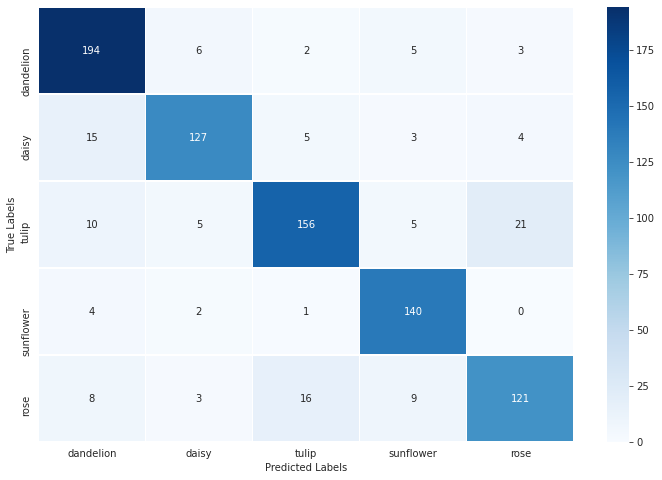

In [26]:
cm = confusion_matrix(y_test_inv, predictions)
cm = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(12,8))
sns.heatmap(cm, cmap='Blues', linecolor='white', linewidth=0.5, annot=True,
            fmt='', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

In [27]:
i = 0
misclassified_class = []

for i in range(len(y_test_inv)):
    if(y_test_inv[i] != predictions[i]):
        misclassified_class.append(i)
    if(len(misclassified_class) == 9):
        break

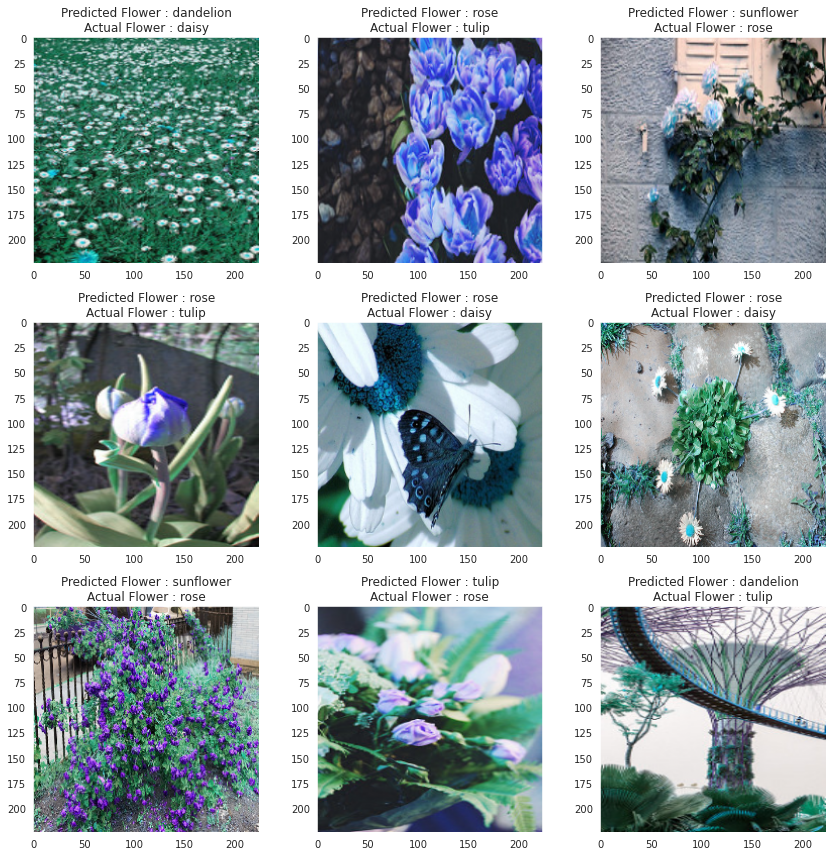

In [28]:
count = 0

fig, ax = plt.subplots(3,3)
fig.set_size_inches(12,12)
for i in range(3):
    for j in range(3):
        ax[i,j].imshow(X_test[misclassified_class[count]])
        ax[i,j].set_title('Predicted Flower : ' + labels[predictions[misclassified_class[count]]] +
                          '\n' +
                          'Actual Flower : ' + labels[y_test_inv[misclassified_class[count]]])
        count += 1

plt.tight_layout()